## SCRAP: load and process the 3D data

In [1]:
from __future__ import print_function
from scipy.spatial import ConvexHull
from skimage.transform import downscale_local_mean
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from skimage.measure import regionprops
import numpy as np
import matplotlib.pyplot as plt
import os as os
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)
from scipy.io import loadmat
import numpy as np
import pandas as pd

In [2]:


x = loadmat('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/20180123_BS10_light.mat')
geneinfo = pd.read_csv('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

In [7]:
# do normalization
e = np.matrix(x['expr'])
df = pd.DataFrame(e)
df.columns = geneinfo['gene']
df2 = df.loc[df.sum(1) != 0] # remove cells where total library count is zero
Ei = df2.median(1) # get row-wise median
sumE1 = df2.sum(1) # get row-wise sum
temp = df2.div(sumE1, axis=0) # divide each column by the row-wise sum
norm_exp = np.log(1 + temp.multiply(Ei, axis = 'index')) # mulitply each column by the median

# get coordinates
c = np.matrix(x['goodLocs'])
cdf = pd.DataFrame(c)
cdf.columns = ['x','y','z']
cdf2 = cdf.loc[df.sum(1) != 0]

# save output matrix
outdf = pd.concat([norm_exp,cdf2], axis = 1)
outmtx = np.matrix(pd.concat([norm_exp,cdf2], axis = 1))

## load and process one of the 2D datasets

In [578]:
# function from here: https://github.com/weallen/STARmap/blob/master/python/analysis.py
def load_data(data_dir, prefix="Cell"):
        #expr = pd.read_csv(os.path.join(data_dir, "data_table.csv"), index_col=0)
    expr = pd.read_csv(os.path.join(data_dir, "cell_barcode_count.csv"), header=None)
    gene_names = pd.read_csv(os.path.join(data_dir, "cell_barcode_names.csv"),header=None)
    rownames = [i for i in range(expr.shape[0])]
    names = gene_names[2]
    names.name = "Gene"
    return pd.DataFrame(data=expr.values, columns=names, index=rownames)

# function from https://github.com/weallen/STARmap/blob/master/python/viz.py
def GetQHulls(labels):
    labels += 1
    Nlabels = labels.max()
    hulls = []
    coords = []
    num_cells = 0
    #cell_id = []
    #print('blah')
    for i in tqdm(range(Nlabels)):#enumerate(regionprops(labels)):    
        #print(i,"/",Nlabels)
        curr_coords = np.argwhere(labels==i) # get all coordinates for a single cell label
        # size threshold of > 100 pixels and < 100000
        if curr_coords.shape[0] < 100000 and curr_coords.shape[0] > 1000: # if the cell shape is within threshold region, save the coordinates
            num_cells += 1
            hulls.append(ConvexHull(curr_coords))
            coords.append(curr_coords)
        #cell_id = np.append(cell_id, i)
    #print("Used %d / %d" % (num_cells, Nlabels))
    return hulls, coords

## my functions:
def normalize(counts):

    cts = np.array(counts)
    cts = cts[np.array(np.where(np.sum(cts, axis = 1)!=0)).flatten(),:] # remove cells, where total library count is zero
    cell_median = np.median(cts, axis = 1) # get row-wise median
    cell_sum = np.sum(cts, axis = 1) # get row-wise sum
    counts_out = cts/(np.tile(cell_sum, (cts.shape[1],1)).transpose()) # divide each column by row-wise sum
    
    return counts_out

def process_2D(data_dir, gene_names,i):
    
    # load data
    image = np.load(os.path.join(data_dir,'labels.npz'))["labels"]
    counts = load_data(data_dir, prefix="")

    # process counts
    normalized_counts = pd.DataFrame(normalize(counts)) # normalize counts
    normalized_counts.columns = counts.columns
    normalized_counts = normalized_counts.reindex(columns = sorted(gene_names))                
    normalized_counts = np.array(normalized_counts.fillna(0))

    # get coords
    qhulls,coords = GetQHulls(image)# get all coordinates corresponding to single cell
    all_centroids  = np.vstack([np.append(c.mean(0),(0,i)) for c in coords]) # centroids are the average coordinates
    counts_and_coords = np.concatenate((normalized_counts, all_centroids.astype('int')[range(normalized_counts.shape[0]),:]), axis = 1) # concat counts and coords
    
    return counts_and_coords

#def process_3D()

In [495]:
# get union of all gene names (across 3D and 2D datasets)
genenames_3D = pd.read_csv('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

ct = []

for i in range(len(dirs)):
    
    data_dir1 = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])

    ct.append(load_data(data_dir1, prefix=""))

genenames = []
for i in range(len(dirs)):
    genenames.append(ct[i].columns)

all_genes = np.unique(np.concatenate((np.unique(np.concatenate(genenames)),(np.array(genenames_3D).flatten()))))

In [592]:
# process and append all the 2D datasets to one another 
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets') 
data_out = []

for i in range(len(dirs)):
    data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])
    data_out.append([data_out, process_2D(data_dir, all_genes,i)])
    

100%|██████████| 1131/1131 [04:02<00:00,  4.65it/s]


In [593]:
plt.scatter(cc[:,1030],cc[:,1031], c = cc[:,195], cmap='Blues')


[[[...],
  array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.95100000e+03, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.96900000e+03, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.80400000e+03, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 3.64963504e-03, ...,
          2.92600000e+03, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.12500000e-03, ...,
          9.16500000e+03, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.09910000e+04, 0.00000000e+00, 0.00000000e+00]])],
 [[...],
  array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 6.200e+03, 0.000e+00,
          1.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.410e+02, 0.000e+00,
          1.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 1

In [ ]:
np.array(data_out[0]).shape

In [ ]:
# show representative image for each dataset 





In [ ]:
2 +2

In [386]:
image = []

for i in range(len(dirs)):
    
    data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])

    image.append(np.load(os.path.join(data_dir,'labels.npz'))["labels"])


In [392]:
si = []
for i in range(len(image)):
    si.append(np.max(image[i]))

sc = []
for i in range(len(ct)):
    sc.append((ct[i]).shape)
    
    
    

In [513]:
dirs[9]

'20180417_BZ5_control'

In [587]:
data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[9])
cc = process_2D(data_dir, all_genes,1)

100%|██████████| 1131/1131 [03:55<00:00,  4.80it/s]


In [588]:
cc.shape

(1127, 1034)

In [590]:
np.argwhere(all_genes=='Ctgf')

array([[195]])

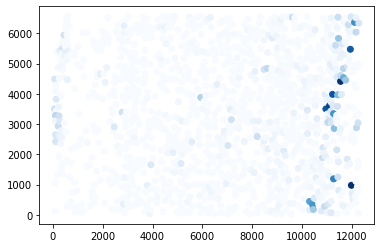

In [591]:
plt.scatter(cc[:,1030],cc[:,1031], c = cc[:,195], cmap='Blues')

In [586]:
dirs

['20180505_BY3_1kgenes',
 '20171110_BF2_dark',
 '20180410-BY3_1kgenes',
 '20180421_BZ19_cocaine',
 '20170915_BD2_dark',
 '20171115_BF5_light',
 '20180424_BZ14_control',
 '20171120_BF4_light',
 '20180419_BZ9_control',
 '20180417_BZ5_control']

In [538]:
cc[:,703][cc[:,703]>0.5] = 0.5

In [543]:
counts = load_data(data_dir)
labs = np.load('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/mpfc_160/20180417_BZ5_control/labels.npz')["labels"]
qhulls,coords = GetQHulls(labs)

100%|██████████| 1131/1131 [03:56<00:00,  4.77it/s]


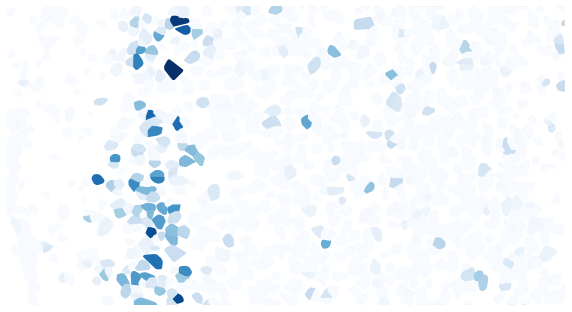

In [548]:
plot_poly_cells_expression(labs, qhulls, counts['Cux2'], 'Blues',width=10, height=10,)

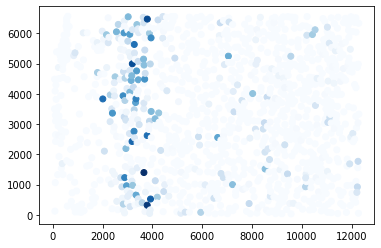

In [552]:
all_centroids  = np.vstack([c.mean(0) for c in coords]) # centroids are the average coordinates

plt.scatter(all_centroids[:,0],all_centroids[:,1], c =  counts['Cux2'], cmap='Blues')

In [574]:
np.argwhere(counts.columns == 'Cux2')

array([[32]])

In [573]:
f = normalize(np.array(counts))

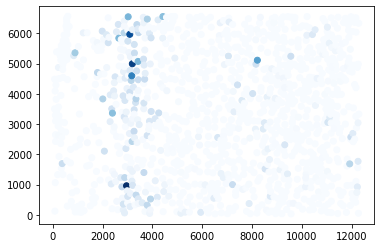

In [575]:
ct_norm = pd.DataFrame(normalize(counts))
ct_norm.columns = counts.columns
plt.scatter(all_centroids[:,0],all_centroids[:,1], c = f[:,32], cmap='Blues')

In [577]:
len(f.sum(1))

1127

In [567]:
df = counts
df2 = df.loc[df.sum(1) != 0] # remove cells where total library count is zero
Ei = df2.median(1) # get row-wise median
sumE1 = df2.sum(1) # get row-wise sum
temp = df2.div(sumE1, axis=0) # divide each column by the row-wise sum
#norm_exp =temp.multiply(Ei, axis = 'index')# mulitply each column by the median
norm_exp = temp

In [569]:
norm_exp.sum(1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      1.0
       ... 
1097    1.0
1098    1.0
1099    1.0
1100    1.0
1101    1.0
1102    1.0
1103    1.0
1104    1.0
1105    1.0
1106    1.0
1107    1.0
1108    1.0
1109    1.0
1110    1.0
1111    1.0
1112    1.0
1113    1.0
1114    1.0
1115    1.0
1116    1.0
1117    1.0
1118    1.0
1119    1.0
1120    1.0
1121    1.0
1122    1.0
1123    1.0
1124    1.0
1125    1.0
1126    1.0
Length: 1127, dtype: float64

In [544]:

def plot_poly_cells_expression(nissl, hulls, expr, cmap, good_cells=None,width=2, height=9,figscale=10,alpha=1):
    figscale = 10
    plt.figure(figsize=(figscale*width/float(height),figscale))
    polys = [hull_to_polygon(h) for h in hulls]
    if good_cells is not None:
        polys = [p for i,p in enumerate(polys) if i in good_cells]
    p = PatchCollection(polys,alpha=alpha, cmap=cmap,linewidths=0)
    p.set_array(expr)
    p.set_clim(vmin=0, vmax=expr.max())        
    plt.gca().add_collection(p)
    plt.imshow(nissl.T, cmap=plt.cm.gray_r,alpha=0.15)
    plt.axis('off')

In [496]:
data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[1])
cc = process_2D(data_dir, all_genes,1)

100%|██████████| 1174/1174 [00:45<00:00, 25.63it/s]


In [475]:
counts = load_data(data_dir, prefix="")

In [488]:
normalized_counts = pd.DataFrame(normalize(counts)) # normalize counts
normalized_counts.columns = counts.columns
normalized_counts = normalized_counts.reindex(columns = sorted(gene_names))                
normalized_counts = np.array(normalized_counts.fillna(0))
np.max(normalized_counts[:,61])

5.484796933490655

In [498]:
[np.where(all_genes=='Cux2')]

[(array([201]),)]

In [505]:
all_genes.shape

(1030,)

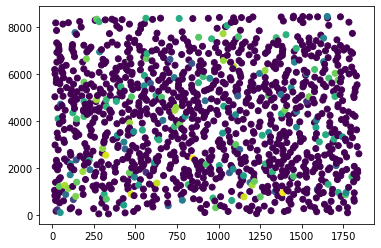

In [511]:
plt.scatter(cc[:,1030],cc[:,1031], c = cc[:,201])

In [510]:
cc[:,1030:1033]

array([[  15., 6200.,    0.],
       [  16.,  841.,    0.],
       [  23.,  180.,    0.],
       ...,
       [1836., 1829.,    0.],
       [1829., 3635.,    0.],
       [1843., 2618.,    0.]])

In [509]:
cc.shape

(1151, 1034)

In [465]:
np.max(cc[:,0:len(all_genes)])

0.0

In [461]:
dirs

['20180505_BY3_1kgenes',
 '20171110_BF2_dark',
 '20180410-BY3_1kgenes',
 '20180421_BZ19_cocaine',
 '20170915_BD2_dark',
 '20171115_BF5_light',
 '20180424_BZ14_control',
 '20171120_BF4_light',
 '20180419_BZ9_control',
 '20180417_BZ5_control']

In [348]:
data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[1])
d2_cts, d2_ctrd = process_2D(data_dir, all_genes,2)

100%|██████████| 1174/1174 [00:45<00:00, 25.86it/s]


In [349]:
d2_cts.shape

(1151, 1057)

In [362]:
normalized_counts[np.array(range(0,Nlabels)),:].shape

(1173, 1057)

In [381]:
d2_cts.shape

(1151, 1057)

In [ ]:
normalized_counts[range(all_centroids.shape[0]),:]

In [384]:
np.concatenate((normalized_counts[range(all_centroids.shape[0]),:], all_centroids.astype('int')), axis = 1) # concat counts and coords


array([[1.56628774e+01, 6.20066075e+03, 0.00000000e+00, 2.00000000e+00],
       [1.63592077e+01, 8.41387045e+02, 0.00000000e+00, 2.00000000e+00],
       [2.38864307e+01, 1.80547935e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.83640229e+03, 1.82972762e+03, 0.00000000e+00, 2.00000000e+00],
       [1.82959871e+03, 3.63547095e+03, 0.00000000e+00, 2.00000000e+00],
       [1.84310203e+03, 2.61889431e+03, 0.00000000e+00, 2.00000000e+00]])

In [ ]:
# output is:

#### gene expression values in order of all_genes ### x y z coords ### data ID ###

### Data 1 (2D)

### Data 2 (2D)

### Data 3 (2D)

### ....


In [ ]:
# process the 3D dataset



In [ ]:
# concatenate 2D and 3D data



# save as .npz, save allgenes, and save data index (where i corresponds to i in len(Dirs))

In [ ]:
# use the last column in the concatenated counts matrix to determine which dataset the data comes from
# 